##  1: Create SKLearn Compliant functions for SQRTLasso and SCAD

In [229]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from scipy.linalg import toeplitz
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV



In [231]:
from sklearn.base import BaseEstimator, RegressorMixin

class SCAD(BaseEstimator, RegressorMixin):
    def __init__(self, a=2,lam=1):
        self.a, self.lam = a, lam
        from sklearn.base import BaseEstimator, RegressorMixin
  
    def fit(self, x, y):
        a = self.a
        lam   = self.lam

        def scad(beta):
          beta = beta.flatten()
          beta = beta.reshape(-1,1)
          n = len(y)
          return 1/n*np.sum((y-x.dot(beta))**2) + np.sum(scad_penalty(beta,lam,a))

        def dscad(beta):
          beta = beta.flatten()
          beta = beta.reshape(-1,1)
          n = len(y)
          output = -2/n*np.transpose(x).dot(y-x.dot(beta))+scad_derivative(beta,lam,a)
          return output.flatten()
        
        
        beta0 = np.zeros(p)
        output = minimize(scad, beta0, method='L-BFGS-B', jac=dscad,options={'gtol': 1e-8, 'maxiter': 50000,'maxls': 50,'disp': False})
        beta = output.x
        self.coef_ = beta
        
    def predict(self, x):
        return x.dot(self.coef_)



def scad_penalty(beta_hat, lambda_val, a_val):
    is_linear = (np.abs(beta_hat) <= lambda_val)
    is_quadratic = np.logical_and(lambda_val < np.abs(beta_hat), np.abs(beta_hat) <= a_val * lambda_val)
    is_constant = (a_val * lambda_val) < np.abs(beta_hat)
    
    linear_part = lambda_val * np.abs(beta_hat) * is_linear
    quadratic_part = (2 * a_val * lambda_val * np.abs(beta_hat) - beta_hat**2 - lambda_val**2) / (2 * (a_val - 1)) * is_quadratic
    constant_part = (lambda_val**2 * (a_val + 1)) / 2 * is_constant
    return linear_part + quadratic_part + constant_part

    
def scad_derivative(beta_hat, lambda_val, a_val):
    return lambda_val * ((beta_hat <= lambda_val) + (a_val * lambda_val - beta_hat)*((a_val * lambda_val - beta_hat) > 0) / ((a_val - 1) * lambda_val) * (beta_hat > lambda_val))



def scad(beta):
  beta = beta.flatten()
  beta = beta.reshape(-1,1)
  n = len(y)
  return 1/n*np.sum((y-x.dot(beta))**2) + np.sum(scad_penalty(beta,lam,a))

  
def dscad(beta):
  beta = beta.flatten()
  beta = beta.reshape(-1,1)
  n = len(y)
  output = -2/n*np.transpose(x).dot(y-x.dot(beta))+scad_derivative(beta,lam,a)
  return output.flatten()

In [92]:
class SQRTLasso(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def fit(self, x, y):
        alpha=self.alpha
        def f_obj(x,y,beta,alpha):
          n =len(x)
          beta = beta.flatten()
          beta = beta.reshape(-1,1)
          output = np.sqrt(1/n*np.sum((y-x.dot(beta))**2)) + alpha*np.sum(np.abs(beta))
          return output
        
        def f_grad(x,y,beta,alpha):
          n=x.shape[0]
          p=x.shape[1]
          beta = beta.flatten()
          beta = beta.reshape(-1,1)
          output = np.array((-1/np.sqrt(n))*np.transpose(x).dot(y-x.dot(beta))/np.sqrt(np.sum((y-x.dot(beta))**2))+alpha*np.sign(beta)).flatten()
          return output
        
        def objective(beta):
          return(f_obj(x,y,beta,alpha))
        
        def gradient(beta):
          return(f_grad(x,y,beta,alpha))
        
        beta0 = np.ones((x.shape[1],1))
        output = minimize(objective, beta0, method='L-BFGS-B', jac=gradient,options={'gtol': 1e-8, 'maxiter': 50000,'maxls': 25,'disp': True})
        beta = output.x
        self.coef_ = beta
        
    def predict(self, x):
        return x.dot(self.coef_)

## 2: Simulate 100 datasets, each with 1200 fetures and 200 observations and a toeplitz structure

In [94]:
# The desired mean values of the sample.
n = 200
p= 1200

Xdata = []
ydata = []

beta_star = np.concatenate(([1]*7, [0]*25, [0.25]*5, [0]*50, [0.7]*15, [0]*1098))

mu = [0]*p
sigma = 3.5
np.random.seed(123)

v = []
for i in range(p):
    v.append(0.8**i) #1D array (vector) of 0.8**i

r = toeplitz(v)

# Generate the random samples.
for i in range(0,100):
    X = np.random.multivariate_normal(mu, r, size=n) #make some fake data
    y = X.dot(beta_star) + sigma*np.random.normal(loc=0,scale=1,size=n) #actual target plus st.d times a random.normal noise
    #Note that np.matmul (matrix multiplication) gives you a numpy array
    Xdata.append(X)
    ydata.append(y)


## 3: Apply Ridge, Lasso, Elastic Net, SCAD and Square Root Lasso to each dataset, and record the average quality of reconstructing the sparsity pattern and the coefficients of $\beta^*$

In [200]:
def validate(model, X, y, nfolds, rs):
    from sklearn.model_selection import KFold, train_test_split as tts
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=rs)
    PE = []
    for idxtrain, idxtest in kf.split(X):
        xtrain = X[idxtrain]
        ytrain = y[idxtrain]
        ytest = y[idxtest]
        xtest = X[idxtest]
        #xtrain = scale.fit_transform(xtrain)
        #xtest = scale.transform(xtest)
        model.fit(xtrain,ytrain)
        PE.append(mean_squared_error(ytest,model.predict(xtest)))
    return np.mean(PE)

In [201]:
model = SQRTLasso(alpha=0.1)
model.fit(Xdata[2],ydata[2].reshape(-1,1))
beta_hat = model.coef_

#The L2 norm between the SQRTLasso coefficients and the ground truth
np.linalg.norm(beta_hat - beta_star, ord=2)

1.666247220332228

In [202]:
len(np.where(beta_hat > 0.3)[0])

26

In [203]:
print('Predicted variable selection found this many non-zero variables: ' +str(len(np.where(beta_hat != 0)[0])))
print('The data really has this many non-zero variables: ' +str(len(np.where(beta_star != 0)[0])))

#This is the number of non-zero variables that were correctly found to be non-zero
print("The Number of Correctly Assigned Non-Zeros Was: " + str(len(np.intersect1d(np.where(beta_star != 0), np.where(beta_hat != 0)))))

Predicted variable selection found this many non-zero variables: 1200
The data really has this many non-zero variables: 27
The Number of Correctly Assigned Non-Zeros Was: 27


### Grid searches to find best hyper parameters

In [235]:
grid = GridSearchCV(estimator=ElasticNet(fit_intercept=False, max_iter=10000), cv=10, scoring='neg_mean_squared_error', 
                    param_grid={'alpha':np.linspace(0,1,50),'l1_ratio':np.linspace(0,1,num=50)})
gs_results = grid.fit(Xdata[0],ydata[0])

print(gs_results.best_params_)
print('The mean square error is for Elastic Net: ', np.abs(gs_results.best_score_))

C:\Users\mnelk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mnelk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mnelk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\mnelk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no r

In [ ]:
grid = GridSearchCV(estimator=Lasso(fit_intercept=False, max_iter=10000), cv=10, scoring='neg_mean_squared_error', param_grid={'alpha':np.linspace(0,1,50)})
gs_results = grid.fit(Xdata[0],ydata[0])

print(gs_results.best_params_)
print('The mean square error is for Lasso: ', np.abs(gs_results.best_score_))

In [ ]:
grid = GridSearchCV(estimator=Ridge(fit_intercept=False, max_iter=10000), cv=10, scoring='neg_mean_squared_error', param_grid={'alpha':np.linspace(0,1,50)})
gs_results = grid.fit(Xdata[0],ydata[0])

print(gs_results.best_params_)
print('The mean square error is for Ridge: ', np.abs(gs_results.best_score_))

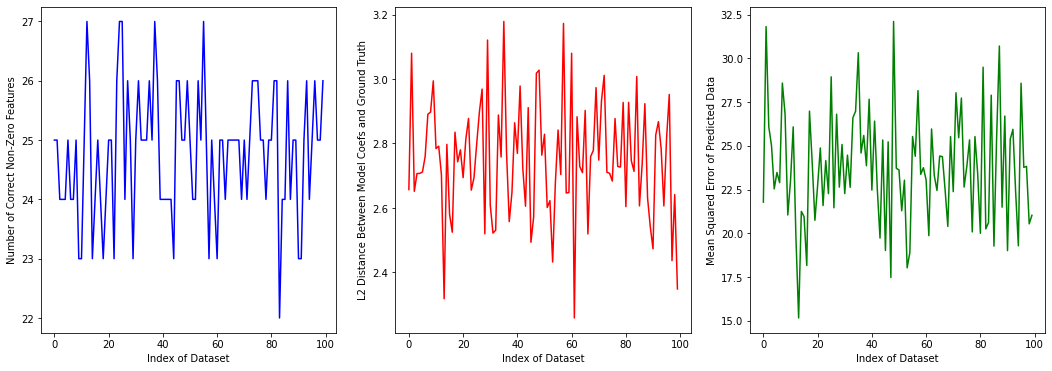

Mean correct non-zeros 24.79
Mean L2 2.751559123799759
Mean MSE 23.742791628966092


In [223]:
# Elastic Net
non_zeros = []
L2s = []
MSEs = []

for i in range(0,100):
    model = ElasticNet(alpha=0.1, fit_intercept=False, max_iter=10000)
    model.fit(Xdata[i],ydata[i].reshape(-1,1))
    beta_hat = model.coef_

    non_zeros.append(len(np.intersect1d(np.where(beta_star > 0.1), np.where(beta_hat != 0))))
    L2s.append(np.linalg.norm(beta_hat - beta_star, ord=2))
    MSEs.append(validate(model, Xdata[i], ydata[i].reshape(-1,1), 2, 123))

fig, (non_zero, L2, MSE) = plt.subplots(1,3, figsize=(18,6))

non_zero.plot(range(0,100), non_zeros, color='blue')
non_zero.set(xlabel='Index of Dataset',ylabel = 'Number of Correct Non-Zero Features')

L2.plot(range(0,100), L2s, color = 'red')
L2.set(xlabel='Index of Dataset',ylabel = 'L2 Distance Between Model Coefs and Ground Truth')

MSE.plot(range(0,100), MSEs, color='green')
MSE.set(xlabel='Index of Dataset',ylabel = 'Mean Squared Error of Predicted Data')


plt.show()
print('Mean correct non-zeros ' + str(np.mean(non_zeros)))
print('Mean L2 ' + str(np.mean(L2s)))
print('Mean MSE ' + str(np.mean(MSEs)))



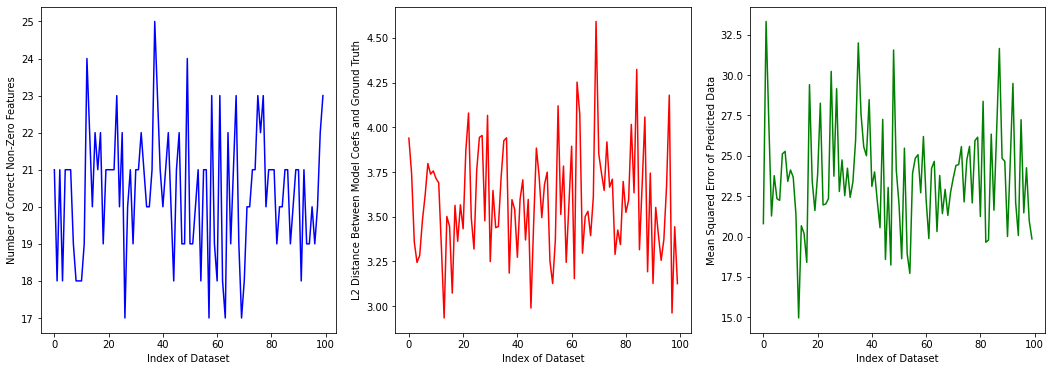

Mean correct non-zeros 20.39
Mean L2 3.5852023017970707
Mean MSE 23.698891039902524


In [224]:
# Lasso
non_zeros = []
L2s = []
MSEs = []

for i in range(0,100):
    model = Lasso(alpha=0.1, fit_intercept=False, max_iter=10000)
    model.fit(Xdata[i],ydata[i].reshape(-1,1))
    beta_hat = model.coef_

    non_zeros.append(len(np.intersect1d(np.where(beta_star > 0.1), np.where(beta_hat != 0))))
    L2s.append(np.linalg.norm(beta_hat - beta_star, ord=2))
    MSEs.append(validate(model, Xdata[i], ydata[i].reshape(-1,1), 2, 123))

fig, (non_zero, L2, MSE) = plt.subplots(1,3, figsize=(18,6))

non_zero.plot(range(0,100), non_zeros, color='blue')
non_zero.set(xlabel='Index of Dataset',ylabel = 'Number of Correct Non-Zero Features')

L2.plot(range(0,100), L2s, color = 'red')
L2.set(xlabel='Index of Dataset',ylabel = 'L2 Distance Between Model Coefs and Ground Truth')

MSE.plot(range(0,100), MSEs, color='green')
MSE.set(xlabel='Index of Dataset',ylabel = 'Mean Squared Error of Predicted Data')


plt.show()
print('Mean correct non-zeros ' + str(np.mean(non_zeros)))
print('Mean L2 ' + str(np.mean(L2s)))
print('Mean MSE ' + str(np.mean(MSEs)))

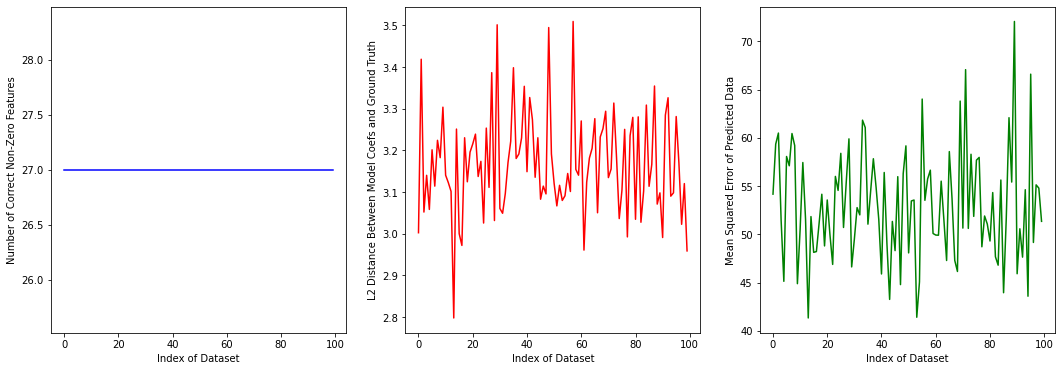

Mean correct non-zeros 27.0
Mean L2 3.167209794939203
Mean MSE 52.92163236150477


In [225]:
# Ridge
non_zeros = []
L2s = []
MSEs = []

for i in range(0,100):
    model = Ridge(alpha=0.1, fit_intercept=False, max_iter=10000)
    model.fit(Xdata[i],ydata[i].reshape(-1,1))
    beta_hat = model.coef_

    non_zeros.append(len(np.intersect1d(np.where(beta_star > 0.1), np.where(beta_hat != 0))))
    L2s.append(np.linalg.norm(beta_hat - beta_star, ord=2))
    MSEs.append(validate(model, Xdata[i], ydata[i].reshape(-1,1), 2, 123))
    
fig, (non_zero, L2, MSE) = plt.subplots(1,3, figsize=(18,6))

non_zero.plot(range(0,100), non_zeros, color='blue')
non_zero.set(xlabel='Index of Dataset',ylabel = 'Number of Correct Non-Zero Features')

L2.plot(range(0,100), L2s, color = 'red')
L2.set(xlabel='Index of Dataset',ylabel = 'L2 Distance Between Model Coefs and Ground Truth')

MSE.plot(range(0,100), MSEs, color='green')
MSE.set(xlabel='Index of Dataset',ylabel = 'Mean Squared Error of Predicted Data')


plt.show()
print('Mean correct non-zeros ' + str(np.mean(non_zeros)))
print('Mean L2 ' + str(np.mean(L2s)))
print('Mean MSE ' + str(np.mean(MSEs)))


In [226]:
# SQRTLasso
non_zeros = []
L2s = []
MSEs = []

for i in range(0,100):
    model = SQRTLasso(alpha=0.1)
    model.fit(Xdata[i],ydata[i].reshape(-1,1))
    beta_hat = model.coef_

    non_zeros.append(len(np.intersect1d(np.where(beta_star > 0.1), np.where(beta_hat != 0))))
    L2s.append(np.linalg.norm(beta_hat - beta_star, ord=2))
    MSEs.append(validate(model, Xdata[i], ydata[i].reshape(-1,1), 2, 123))

fig, (non_zero, L2, MSE) = plt.subplots(1,3, figsize=(18,6))

non_zero.plot(range(0,100), non_zeros, color='blue')
non_zero.set(xlabel='Index of Dataset',ylabel = 'Number of Correct Non-Zero Features')

L2.plot(range(0,100), L2s, color = 'red')
L2.set(xlabel='Index of Dataset',ylabel = 'L2 Distance Between Model Coefs and Ground Truth')

MSE.plot(range(0,100), MSEs, color='green')
MSE.set(xlabel='Index of Dataset',ylabel = 'Mean Squared Error of Predicted Data')


plt.show()
print('Mean correct non-zeros ' + str(np.mean(non_zeros)))
print('Mean L2 ' + str(np.mean(L2s)))
print('Mean MSE ' + str(np.mean(MSEs)))


KeyboardInterrupt: 

In [227]:
# SCAD
non_zeros = []
L2s = []
MSEs = []

for i in range(0,100):
    model = SCAD(a=0.1, lam=1)
    model.fit(Xdata[i],ydata[i].reshape(-1,1))
    beta_hat = model.coef_

    non_zeros.append(len(np.intersect1d(np.where(beta_star > 0.1), np.where(beta_hat != 0))))
    L2s.append(np.linalg.norm(beta_hat - beta_star, ord=2))
    MSEs.append(validate(model, Xdata[i], ydata[i].reshape(-1,1), 2, 123))

fig, (non_zero, L2, MSE) = plt.subplots(1,3, figsize=(18,6))

non_zero.plot(range(0,100), non_zeros, color='blue')
non_zero.set(xlabel='Index of Dataset',ylabel = 'Number of Correct Non-Zero Features')

L2.plot(range(0,100), L2s, color = 'red')
L2.set(xlabel='Index of Dataset',ylabel = 'L2 Distance Between Model Coefs and Ground Truth')

MSE.plot(range(0,100), MSEs, color='green')
MSE.set(xlabel='Index of Dataset',ylabel = 'Mean Squared Error of Predicted Data')


plt.show()
print('Mean correct non-zeros ' + str(np.mean(non_zeros)))
print('Mean L2 ' + str(np.mean(L2s)))
print('Mean MSE ' + str(np.mean(MSEs)))


NameError: name 'scad_penalty' is not defined